### Figure 1. Example data diagrams

In [6]:
from Baselines.KalmanDecoder import * 
from SNNModel.dataloader import *
from Globals import *

In [129]:
FINGER2CURSOR = np.array([[0,0],[-10,0],[0,-10]])

In [45]:
dataloader = Dataloader(spike_units='all', normalize=False, center_zero=True, bin_size=25, bad_ch_cutoff=-1)

Loading indy_20160630_01.mat
Loaded pr dataset
Binned into 100ms intervals
(6899, 3)


In [155]:
trainX_no_lag, testX_no_lag, trainY_no_lag, testY_no_lag, trainY_cursor_no_lag, testY_cursor_no_lag = dataloader()
train_finger_pos, test_finger_pos, train_cursor_pos, test_cursor_pos = dataloader.pos

In [119]:
lag = 0 # we will assume a 200ms lag

# realign data to take lag into account 
trainY = trainY_no_lag; testY = testY_no_lag
trainY_cursor = trainY_cursor_no_lag; testY_cursor = testY_cursor_no_lag
trainX = trainX_no_lag; testX = testX_no_lag

In [120]:
# aggreagate all channels

trainX0 = np.zeros(shape=(trainX.shape[0], 96))

for i in range(1, 5): 
    trainX0 += trainX[:,96*i:96*(i+1)] 
trainX = trainX0

testX0 = np.zeros(shape=(testX.shape[0], 96))

for i in range(1, 5): 
    testX0 += testX[:,96*i:96*(i+1)] 
testX = testX0

In [121]:
dataloader2 = Dataloader(spike_units='all', normalize=False, center_zero=False, bin_size=2, bad_ch_cutoff=-1)

Loading indy_20160630_01.mat
Loaded pr dataset
Binned into 8ms intervals


In [122]:
_, _, y_train_vel_disp, _, _, _ = dataloader2()

In [123]:
def vel2pos(pos, vel): 
    n_outputs = vel.shape[1]
    pos0 = pos[0,:].numpy()
    vel_cumsum = np.concatenate([np.zeros([1, n_outputs]), np.cumsum(vel, axis=0)], axis=0)
    displacement = vel_cumsum 
    return pos0 + displacement

In [128]:
trainY.shape

(6899, 3)

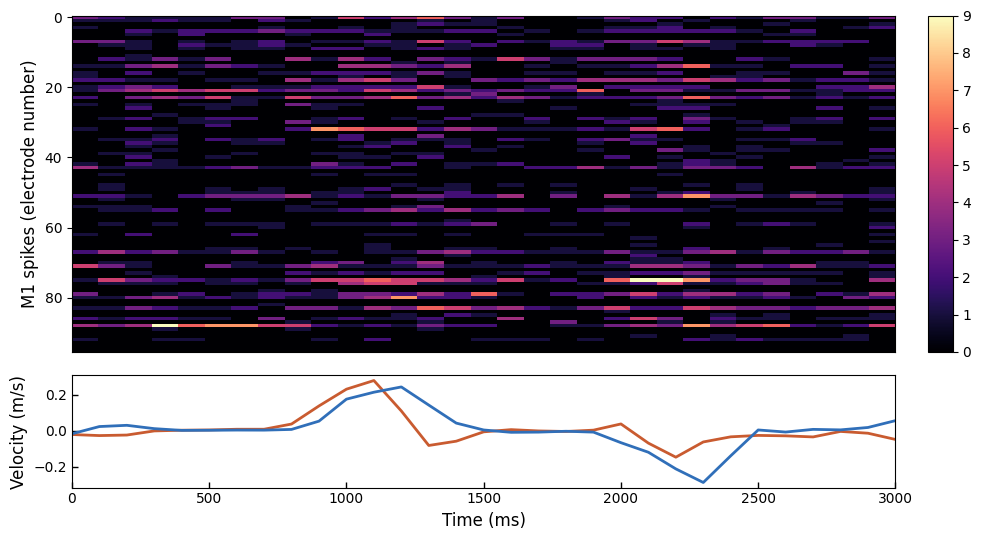

In [176]:
# plot first 1 second 

import matplotlib.pyplot as plt 

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib as mpl

# Create a figure
fig = plt.figure(figsize=(10, 5.5))  # Adjust the size as needed

# Set up GridSpec
gs = gridspec.GridSpec(2, 2, height_ratios=[3, 1], width_ratios=[20, .6])

plot_cursor_vel = trainY @ FINGER2CURSOR

# Add plots
ax0 = fig.add_subplot(gs[0, 0])  # First plot for the heatmap
ax1 = fig.add_subplot(gs[1, 0])  # Second plot for the first line plot

neural_array = trainX.T[:,1510:1541]

# Plotting the heatmap
t = np.linspace(0, 3000, 31)
x_t = np.linspace(0, 3000, 7)
heatmap = ax0.imshow(neural_array, cmap=mpl.colormaps['magma'], aspect='auto')
ax0.set_ylabel('M1 spikes (electrode number)', fontsize=12)
ax0.set_xticks([])
# Adding the colorbar
axc = fig.add_subplot(gs[0, 1])
plt.colorbar(heatmap, cax=axc)


# Plotting the first line plot
ax1.plot(t, 0.01 * plot_cursor_vel[1510:1541,0], color='#C95B30', linewidth=2)
ax1.set_xlabel('Time (ms)', fontsize=12)
ax1.set_ylabel('Velocity (m/s)', fontsize=12)

# Plotting the second line plot
ax1.plot(t, 0.01 * plot_cursor_vel[1510:1541,1], color='#306FB9', linewidth=2)
ax1.set_xlim([0,3])
ax1.set_xticks(x_t)
ax1.tick_params(direction='in', width=1, length=4)

# Improve the layout
plt.tight_layout()

# Display the plot
plt.show()


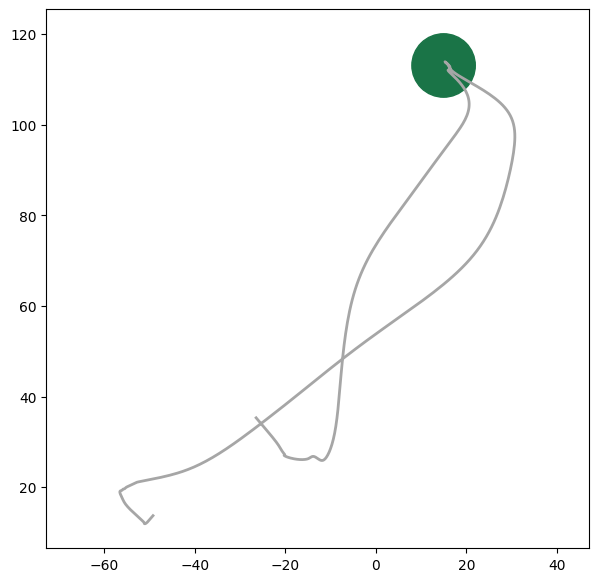

In [224]:
import matplotlib.patches as patches

# Create a figure and an axes
fig, ax = plt.subplots(figsize=(7, 7))

# Define the position and radius of the circle
x, y = train_cursor_pos.numpy()[1510*25:1530*25-20][-1]
radius = 7  # Example radius

# Create a circle patch
circle = patches.Circle((x-1, y+1), radius, color='#1A7447')
# Add the circle to the axes
ax.add_patch(circle)

# Set equal scaling by changing the aspect ratio of the plot
ax.set_aspect('equal', adjustable='datalim')

cursor_loc = train_cursor_pos.numpy()[1510*25:1541*25-1]
ax.plot(cursor_loc[:,0], cursor_loc[:,1], color='#A6A6A6', linewidth=2)

    
# Display the plot
plt.show()


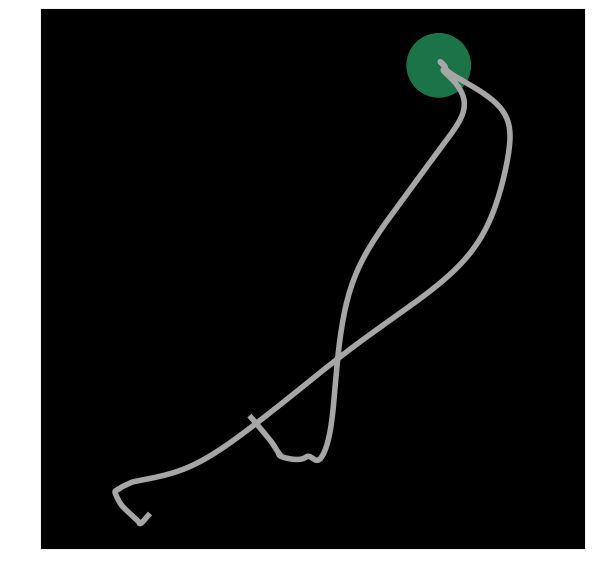

In [228]:
import matplotlib.patches as patches

# Create a figure and an axes
fig, ax = plt.subplots(figsize=(7, 7))

# Define the position and radius of the circle
x, y = train_cursor_pos.numpy()[1510*25:1530*25-20][-1]
radius = 7  # Example radius

# Create a circle patch
circle = patches.Circle((x-1, y+1), radius, color='#1A7447')
# Add the circle to the axes
ax.add_patch(circle)

# Set equal scaling by changing the aspect ratio of the plot
ax.set_aspect('equal', adjustable='datalim')
ax.set_facecolor('black')
#fig.patch.set_facecolor('black')

cursor_loc = train_cursor_pos.numpy()[1510*25:1541*25-1]
ax.plot(cursor_loc[:,0], cursor_loc[:,1], color='#A6A6A6', linewidth=4)
ax.tick_params(axis='both', direction='in', width=2, length=0)
ax.tick_params(colors='white', which='both')  # Change tick color to white


# Display the plot
plt.show()


### Decoding using Kalman filter

In [292]:
import h5py
import numpy as np
import torch
from torch.utils.data import Subset
from neurobench.datasets import PrimateReaching

data_path = './data/indy_20160630_01.mat'


class Dataloader:
    def __init__(self, spike_units='all', normalize=True, center_zero=True, aggreagate_chs=True, bin_size=1, bad_ch_cutoff=1):
        """_summary_

        Args:
            spike_units: string of list of spike unit numbers to use (e.g. [0, 2, 4])
            normalize (bool, optional): _description_. Defaults to True.
            bin_size (int, optional): _description_. Defaults to 1.
            ex_cutoff : excludes spiking units that spike less than this cutoff value 
        """
        self.pr_dataset = PrimateReaching(file_path='data',
                                          filename="indy_20160630_01.mat",
                                          num_steps=1,
                                          train_ratio=0.5,
                                          bin_width=0.004,
                                          biological_delay=0,
                                          download=False)
        print("Loaded pr dataset")
        
        self.spike_units   = spike_units 
        self.normalize     = normalize 
        self.center_zero   = center_zero 
        self.aggregate_chs = aggreagate_chs
        self.bin_size      = bin_size
        self.bad_ch_cutoff = bad_ch_cutoff
        
        with h5py.File(data_path, 'r') as data:
            # initialize spike units to use 
            if spike_units == 'all': 
                n_sp = data['spikes'].shape[0]
                self.spike_units = [i for i in range(n_sp)]
            
            # get spike matrix and split into train / test set 
            spike_matrix = self._get_spike_mat(data)
            trainX, testX, train_finger_pos, test_finger_pos, train_cursor_pos, test_cursor_pos = self._train_test_split(data, spike_matrix)
            
            # bin data
            if self.bin_size > 1: 
                trainX = self._bin_data(trainX)
                testX  = self._bin_data(testX)

            # convert positions to velocity 
            trainY = self._pos2vel(train_finger_pos)
            testY = self._pos2vel(test_finger_pos)
            trainY_cursor = self._pos2vel(train_cursor_pos)
            testY_cursor = self._pos2vel(test_cursor_pos)            
            print(f'Binned into {4*self.bin_size}ms intervals')
            
            # normalize velocities if necessary 
            if self.normalize: 
                trainX, testX = self._normalize(trainX, testX)
            if self.center_zero: 
                trainY, testY = self._center_zero(trainY, testY)

            # exclude channels that are too sparse 
            trainX, testX = self._exclude_channels(trainX, testX)
            
            self.data = trainX, testX, trainY, testY, trainY_cursor, testY_cursor
            

    def _get_spike_mat(self, data): 
        # extract timesteps and spike channel params
        timesteps = torch.tensor(np.array(data['t'])).flatten()  # Ensure t is a 1D array
        n_ch = len(data['spikes'][0])  # number of channels 
        n_sp = len(self.spike_units)   # number of spike units to use for each channel
        
        # initialize spike matrix with zeros 
        n = len(timesteps)
        k = n_sp * n_ch 
        spike_matrix = np.zeros((n, k), dtype=np.float32)
        
        # read spike data and populate spike matrix 
        for sp_unit in self.spike_units: 
            for unit_idx, channel_ref in enumerate(data['spikes'][sp_unit]): 
                channel = data[channel_ref]  # Dereference the channel
                for unit_ref in channel: 
                    unit_spike_times = np.array(unit_ref).flatten()  # Dereference the unit spike times and flatten
                    spike_indices    = np.searchsorted(timesteps, unit_spike_times)
                    spike_indices    = spike_indices[spike_indices < n]  # Ensure indices are within bounds
                    spike_matrix[spike_indices, sp_unit*n_ch+unit_idx] = 1
                    
        return spike_matrix
    
    
    def _train_test_split(self, data, spike_matrix):
        finger_pos = torch.tensor(np.array(data['finger_pos']).T)  # Ensure proper shape and convert to PyTorch tensor
        cursor_pos = torch.tensor(np.array(data['cursor_pos']).T)  # Ensure proper shape and convert to PyTorch tensor
        # get train and test indices
        train_idx = self.pr_dataset.ind_train
        test_idx  = self.pr_dataset.ind_test
        
        train_neural = spike_matrix[train_idx]
        test_neural  = spike_matrix[test_idx]
        
        train_finger_pos = finger_pos[train_idx][:,:3]  # extract z, -x, -y positions and drop spherical coords
        test_finger_pos  = finger_pos[test_idx][:,:3]   # extract z, -x, -y positions and drop spherical coords
        
        train_cursor_pos = cursor_pos[train_idx]
        test_cursor_pos  = cursor_pos[test_idx]
        
        return train_neural, test_neural, train_finger_pos, test_finger_pos, train_cursor_pos, test_cursor_pos
        
        
    def _bin_data(self, neural): 
        n_samples, n_spikes = neural.shape
        n_bins = int(np.ceil(n_samples / self.bin_size))
        
        X = np.zeros(shape=(n_bins, n_spikes), dtype=np.float32)
        for bin, i in enumerate(range(0, n_samples, self.bin_size)): 
            X[bin] = np.mean(neural[i:i+self.bin_size], axis=0)
        
        return X


    def _pos2vel(self, y): 
        n_samples, n_outputs = y.shape
        n_bins = int(np.ceil(n_samples / self.bin_size))
        
        y_pos = np.zeros(shape=(n_bins, n_outputs), dtype=np.float32)
        y_vel = np.zeros(shape=(n_bins, n_outputs), dtype=np.float32)
        for bin, i in enumerate(range(0, n_samples, self.bin_size)): 
            binned_y = y[i:i+self.bin_size]
            y_vel[bin] = binned_y[-1] - binned_y[0]
            y_pos[bin] = binned_y[-1]
        
        y_out = np.hstack([y_pos, y_vel])
        return y_out
        
    
    def _normalize(self, trainX, testX): 
        mean = np.mean(trainX, axis=0, keepdims=True)
        std  = np.std(trainX, axis=0, keepdims=True)
        
        return (trainX - mean) / std, (testX - mean) / std
    
    
    def _center_zero(self, trainY, testY): 
        print(trainY.shape)
        mean = np.mean(trainY, axis=0, keepdims=True)
        self.finger_mean_vel = mean 
        return trainY - mean, testY - mean
        
    
    def _exclude_channels(self, trainX, testX): 
        train_chs = np.sum(trainX, axis=0) > self.bad_ch_cutoff
        test_chs  = np.sum(testX, axis=0) > self.bad_ch_cutoff
        all_chs   = np.logical_and(train_chs, test_chs)
        
        return trainX[:,all_chs], testX[:,all_chs]
    
    
    def __call__(self): 
        return self.data


In [293]:
dataloader = Dataloader(spike_units='all', normalize=False, center_zero=True, aggreagate_chs=True, bin_size=25, bad_ch_cutoff=1)

Loading indy_20160630_01.mat
Loaded pr dataset
Binned into 100ms intervals
(6899, 6)


In [410]:
trainX, testX, trainY, testY, trainY_cursor, testY_cursor = dataloader()

In [411]:
## initialize kalman filter regression
from numpy.linalg import inv 

class KalmanFilterRegression(object):

    """
    Class for the Kalman Filter Decoder

    Parameters
    -----------
    C - float, optional, default 1
    This parameter scales the noise matrix associated with the transition in kinematic states.
    It effectively allows changing the weight of the new neural evidence in the current update.

    Our implementation of the Kalman filter for neural decoding is based on that of Wu et al 2003 (https://papers.nips.cc/paper/2178-neural-decoding-of-cursor-motion-using-a-kalman-filter.pdf)
    with the exception of the addition of the parameter C.
    The original implementation has previously been coded in Matlab by Dan Morris (http://dmorris.net/projects/neural_decoding.html#code)
    """

    def __init__(self,C=1):
        self.C=C


    def fit(self,X_kf_train,y_train):

        """
        Train Kalman Filter Decoder

        Parameters
        ----------
        X_kf_train: numpy 2d array of shape [n_samples(i.e. timebins) , n_neurons]
            This is the neural data in Kalman filter format.
            See example file for an example of how to format the neural data correctly

        y_train: numpy 2d array of shape [n_samples(i.e. timebins), n_outputs]
            This is the outputs that are being predicted
        """

        #First we'll rename and reformat the variables to be in a more standard kalman filter nomenclature (specifically that from Wu et al, 2003):
        #xs are the state (here, the variable we're predicting, i.e. y_train)
        #zs are the observed variable (neural data here, i.e. X_kf_train)
        X=np.matrix(y_train.T)
        Z=np.matrix(X_kf_train.T)

        #number of time bins
        nt=X.shape[1]

        #Calculate the transition matrix (from x_t to x_t+1) using least-squares, and compute its covariance
        #In our case, this is the transition from one kinematic state to the next
        X2 = X[:,1:]
        X1 = X[:,0:nt-1]
        A=X2*X1.T*inv(X1*X1.T) #Transition matrix
        W=(X2-A*X1)*(X2-A*X1).T/(nt-1)/self.C #Covariance of transition matrix. Note we divide by nt-1 since only nt-1 points were used in the computation (that's the length of X1 and X2). We also introduce the extra parameter C here.

        #Calculate the measurement matrix (from x_t to z_t) using least-squares, and compute its covariance
        #In our case, this is the transformation from kinematics to spikes
        H = Z*X.T*(inv(X*X.T)) #Measurement matrix
        Q = ((Z - H*X)*((Z - H*X).T)) / nt #Covariance of measurement matrix
        params=[A,W,H,Q]
        self.model=params

    def predict(self,X_kf_test,y_test):

        """
        Predict outcomes using trained Kalman Filter Decoder

        Parameters
        ----------
        X_kf_test: numpy 2d array of shape [n_samples(i.e. timebins) , n_neurons]
            This is the neural data in Kalman filter format.

        y_test: numpy 2d array of shape [n_samples(i.e. timebins),n_outputs]
            The actual outputs
            This parameter is necesary for the Kalman filter (unlike other decoders)
            because the first value is nececessary for initialization

        Returns
        -------
        y_test_predicted: numpy 2d array of shape [n_samples(i.e. timebins),n_outputs]
            The predicted outputs
        """

        #Extract parameters
        A,W,H,Q=self.model

        #First we'll rename and reformat the variables to be in a more standard kalman filter nomenclature (specifically that from Wu et al):
        #xs are the state (here, the variable we're predicting, i.e. y_train)
        #zs are the observed variable (neural data here, i.e. X_kf_train)
        X=np.matrix(y_test.T)
        Z=np.matrix(X_kf_test.T)

        #Initializations
        num_states=X.shape[0] #Dimensionality of the state
        states=np.empty(X.shape) #Keep track of states over time (states is what will be returned as y_test_predicted)
        P_m=np.matrix(np.zeros([num_states,num_states]))
        P=np.matrix(np.zeros([num_states,num_states]))
        state=X[:,0] #Initial state
        states[:,0]=np.copy(np.squeeze(state))

        #Get predicted state for every time bin
        for t in tqdm(range(X.shape[1]-1)):
            #Do first part of state update - based on transition matrix
            P_m=A*P*A.T+W
            state_m=A*state

            #Do second part of state update - based on measurement matrix
            K=P_m*H.T*inv(H*P_m*H.T+Q) #Calculate Kalman gain
            P=(np.matrix(np.eye(num_states))-K*H)*P_m
            state=state_m+K*(Z[:,t+1]-H*state_m)
            states[:,t+1]=np.squeeze(state) #Record state at the timestep
        y_test_predicted=states.T
        return y_test_predicted




In [412]:
KFR = KalmanFilterRegression(C=1)
KFR.fit(trainX, trainY)
## We will use only the first 1000 datapoints for visualization / testing purposes
y_train_pred = KFR.predict(trainX, trainY) + dataloader.finger_mean_vel
y_pred = KFR.predict(testX, testY) + dataloader.finger_mean_vel

100%|██████████| 4297/4297 [00:13<00:00, 330.44it/s]


In [413]:
cursor_train_pred = y_train_pred[:,:3] @ FINGER2CURSOR
cursor_pred = y_pred[:,:3] @ FINGER2CURSOR
cursor_vel_train_pred = y_train_pred[:,3:] @ FINGER2CURSOR
cursor_vel_pred = y_pred[:,3:] @ FINGER2CURSOR

In [414]:
actual_values = testY_cursor[:,:2]
predictions = cursor_pred[:,:2]

from sklearn.metrics import mean_squared_error

def rmse_percentage(actual_values, predictions): 
    rmse = np.sqrt(mean_squared_error(actual_values, predictions))

    target_range = np.max(actual_values) - np.min(actual_values)

    percentage_accuracy = (1.0 - (rmse / target_range)) * 100
    return percentage_accuracy

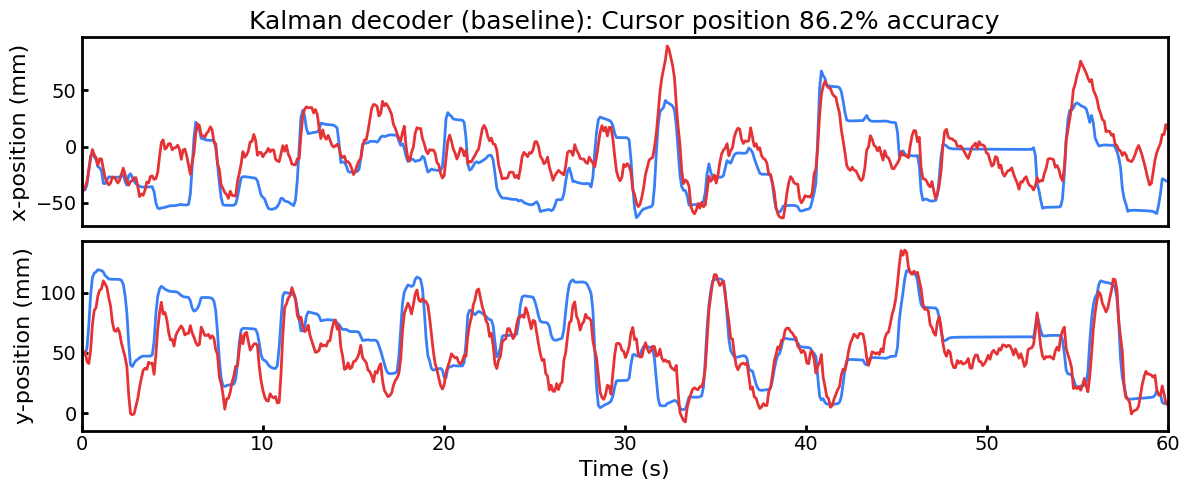

In [415]:
plot_points = 600
t = np.linspace(0, 60, 7)
t_idx = np.linspace(0, 60, plot_points)

fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs = axs.flatten()
axs[0].set_xticks([])

axs[0].plot(t_idx, testY_cursor[:plot_points,0], color='#387FF7', linewidth=2)
axs[0].plot(t_idx, cursor_pred[:plot_points,0], color='#E53235', linewidth=2)

axs[1].plot(t_idx, testY_cursor[:plot_points,1], color='#387FF7', linewidth=2)
axs[1].plot(t_idx, cursor_pred[:plot_points,1], color='#E53235', linewidth=2)
         
         
axs[0].set_xlim([0, 60])
axs[1].set_xlim([0, 60])
axs[1].set_xlabel("Time (s)", fontsize=16)
axs[0].set_ylabel("x-position (mm)", fontsize=16)
axs[1].set_ylabel("y-position (mm)", fontsize=16)

axs[0].tick_params(direction='in', width=2, length=4)
axs[1].tick_params(direction='in', width=2, length=4)

axs[0].tick_params(axis='both', which='major', labelsize=14)
axs[1].tick_params(axis='both', which='major', labelsize=14)
axs[0].set_title(f"Kalman decoder (baseline): Cursor position {rmse_percentage(testY_cursor[:,:2], cursor_pred[:,:2]):.1f}% accuracy", fontsize=18)

spine_width = 2  # Width in points, adjust to preference
for spine in axs[0].spines.values():
    spine.set_linewidth(spine_width)
for spine in axs[1].spines.values():
    spine.set_linewidth(spine_width)
    
plt.tight_layout()
plt.show()

In [416]:
def plot(testY_cursor, cursor_pred): 
    plot_points = 600
    t = np.linspace(0, 60, 7)
    t_idx = np.linspace(0, 60, plot_points)

    fig, axs = plt.subplots(2, 1, figsize=(12, 5))
    axs = axs.flatten()
    axs[0].set_xticks([])

    axs[0].plot(t_idx, testY_cursor[:plot_points,0], color='#387FF7', linewidth=2)
    axs[0].plot(t_idx, cursor_pred[:plot_points,0], color='#E53235', linewidth=2)

    axs[1].plot(t_idx, testY_cursor[:plot_points,1], color='#387FF7', linewidth=2)
    axs[1].plot(t_idx, cursor_pred[:plot_points,1], color='#E53235', linewidth=2)
            
            
    axs[0].set_xlim([0, 60])
    axs[1].set_xlim([0, 60])
    axs[1].set_xlabel("Time (s)", fontsize=16)
    axs[0].set_ylabel("x-position (mm)", fontsize=16)
    axs[1].set_ylabel("y-position (mm)", fontsize=16)

    axs[0].tick_params(direction='in', width=2, length=4)
    axs[1].tick_params(direction='in', width=2, length=4)

    axs[0].tick_params(axis='both', which='major', labelsize=14)
    axs[1].tick_params(axis='both', which='major', labelsize=14)
    axs[0].set_title(f"Kalman decoder (baseline): Cursor position {rmse_percentage(testY_cursor[:,:2], cursor_pred[:,:2]):.1f}% accuracy", fontsize=18)

    spine_width = 2  # Width in points, adjust to preference
    for spine in axs[0].spines.values():
        spine.set_linewidth(spine_width)
    for spine in axs[1].spines.values():
        spine.set_linewidth(spine_width)
        
    plt.tight_layout()
    plt.show()

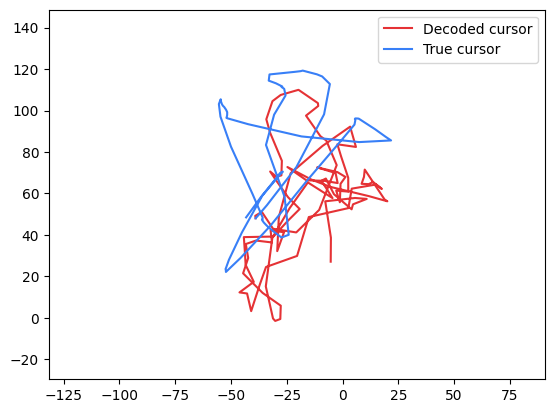

In [424]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Assuming cursor_pred and testY_cursor are defined elsewhere in your code
# For example, these could be your predicted cursor positions and actual test positions
# Here are some dummy initializations for demonstration purposes

start = 0
end = 100

fig, ax = plt.subplots()
line1, = ax.plot([], [], color='#E53235', label='Decoded cursor')  # Line for cursor_pred, red line
line2, = ax.plot([], [], color='#387FF7', label='True cursor')  # Line for testY_cursor, green line

def init():
    """Initialize the background of the animation."""
    ax.set_xlim(np.min(cursor_pred[:, 0]) - 1, np.max(cursor_pred[:, 0]) + 1)
    ax.set_ylim(np.min(cursor_pred[:, 1]) - 1, np.max(cursor_pred[:, 1]) + 1)
    return line1, line2

def update(frame):
    """Update the plot for each frame."""
    line1.set_data(cursor_pred[start:frame, 0], cursor_pred[start:frame, 1])
    line2.set_data(testY_cursor[start:frame, 0], testY_cursor[start:frame, 1])
    return line1, line2

# Create the animation
ani = FuncAnimation(fig, update, frames=range(start, end + 1),
                    init_func=init, blit=True, interval=100)

# To save the animation, uncomment the line below
ani.save('plot_animation.mp4')
plt.legend()
plt.show()
